In [12]:
import os
import pandas as pd

filedir = os.getcwd()
# filedir = os.path.dirname(os.path.realpath(__file__))
datadir = f"{filedir}/../data"
test_info = pd.read_csv(f"{datadir}/test_info.csv")
test_results = pd.read_csv(f"{datadir}/test_results.csv")
test_specs = pd.read_json(f"{datadir}/test_specs.json", orient="index")
# print(test_specs)
print(test_specs.keys())

Index(['title', 'stepsToReproduce', 'expectedResult'], dtype='object')


In [13]:
import nltk.downloader

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\W+", " ", text)
    # Stemming, only keep word stem
    stop_words = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    text = " ".join(
        stemmer.stem(word) for word in text.split() if word not in stop_words
    )
    return text


def preprocess_list(list_of_texts):
    return [preprocess_text(text) for text in list_of_texts]


test_info["Category"] = test_info["Category"].apply(preprocess_text)
test_info["Test Name"] = test_info["Test Name"].apply(preprocess_text)
test_specs["stepsToReproduce"] = test_specs["stepsToReproduce"].apply(preprocess_list)
test_specs["expectedResult"] = test_specs["expectedResult"].apply(preprocess_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedrive/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print(test_specs.iloc[0])

title                                      1 User with 1 watched page
stepsToReproduce    [log simpl user, access page wiki follow notif...
expectedResult      [user receiv instant 1 2 second notif event ta...
Name: https://test.xwiki.org/xwiki/bin/view/NotificationsPerformances/Events%20appear%20in%20the%20notification%20list/1%20User%20with%201%20watched%20page, dtype: object


In [15]:
from transformers import pipeline
import torch

# Create a pipeline for the BERT model
bert_pipeline = pipeline(
    "feature-extraction",
    model="bert-base-uncased",
    device=0 if torch.cuda.is_available() else -1,
)


def ensure_string_format(data):
    if isinstance(data, str):
        return data
    elif isinstance(data, list):
        return [
            str(item) for item in data
        ]  # Convert each item to string if not already
    else:
        print("WARNING, WRONG DATA")
        print(data)
        return str(data)  # Convert other types to string


def get_bert_embedding(text):
    # Get embeddings using the pipeline
    text = ensure_string_format(text)
    embeddings = bert_pipeline(text, padding=True, truncation=True, max_length=128)
    # Average the token embeddings
    return torch.mean(torch.tensor(embeddings), dim=1).numpy()


def get_bert_embedding_for_list(list_of_text):
    return [get_bert_embedding(text) for text in list_of_text]


# Embeddings for each line
test_info["Category_Embedding"] = test_info["Category"].apply(get_bert_embedding)
test_info["TestName_Embedding"] = test_info["Test Name"].apply(get_bert_embedding)
test_specs["expectedResultEmbeddings"] = test_specs["expectedResult"].apply(get_bert_embedding_for_list)
test_specs["stepsToReproduceEmbeddings"] = test_specs["stepsToReproduce"].apply(get_bert_embedding_for_list)

/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/transformers/pipelines/base.

In [21]:
print(len(test_specs.iloc[0]["expectedResultEmbeddings"]))
print(len(test_specs.iloc[0]["expectedResultEmbeddings"][0]))
print(len(test_specs.iloc[0]["expectedResultEmbeddings"][0][0]))
print(bert_pipeline.model.config)
print(test_specs.iloc[0]["expectedResultEmbeddings"])

2
1
768
BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

[array([[-1.17218450e-01, -4.96398985e-01,  3.49679708e-01,
        -1.25803694e-01,  6.31937906e-02, -2.25977302e-01,
         3.65177125e-01,  4.60522503e-01, -1.11763902e-01,
        -2.03075986e-02, -2.38684371e-01, -2.68473387e-01,
        -7.41095841e-02,  3.31721395e-01, -3.85534883e-01,
         1.73193797e-01, -2.97839604e-02,  7.323

In [42]:
from sklearn.cluster import KMeans
import numpy as np

# Flatten all step embeddings into one list
all_steps_embeddings = [
    np.array(embedding, dtype=np.float32)
    for test_steps in test_specs["stepsToReproduce"]
    for step in test_steps
    for embedding in step
]

# Cluster all embeddings
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(all_steps_embeddings)


# Function to map each step in a test to its cluster
def map_steps_to_clusters(test_steps_embeddings, kmeans_model):
    """
    For each step in the test, determine the cluster it belongs to.
    """
    step_clusters = []
    for step_embeddings in test_steps_embeddings:
        # Convert step embeddings to float32
        step_embeddings_float32 = [
            np.array(embedding, dtype=np.float32) for embedding in step_embeddings
        ]

        # Predict the cluster for each step
        step_cluster = kmeans_model.predict(step_embeddings_float32)
        step_clusters.append(step_cluster)
    return step_clusters


# Apply the mapping function to each test
test_specs["Step_Clusters"] = test_specs["stepsToReproduce"].apply(
    lambda x: map_steps_to_clusters(x, kmeans)
)

# Now test_specs DataFrame contains a new column 'Step_Clusters' with the cluster info for each step
print(test_specs["Step_Clusters"].iloc[0])

/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[array([0], dtype=int32), array([0], dtype=int32), array([1], dtype=int32), array([3], dtype=int32), array([1], dtype=int32), array([3], dtype=int32)]


In [51]:
# Assuming test_specs['stepsToReproduce'] contains the embeddings
first_test_embeddings = [
    embedding for step in test_specs["stepsToReproduce"].iloc[0] for embedding in step
]
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten the embeddings for t-SNE
import numpy as np

# Convert list of embeddings to a 2D NumPy array
flattened_embeddings_array = np.array(flattened_embeddings)

# Then apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(flattened_embeddings_array)

cluster_labels = [
    label[0] for cluster in test_specs["Step_Clusters"].iloc[0] for label in cluster
]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap="viridis"
)
plt.title("t-SNE visualization of Step Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar(scatter)
plt.show()

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming test_specs['stepsToReproduce'] contains the embeddings
first_test_embeddings = [
    embedding for step in test_specs["stepsToReproduce"].iloc[0] for embedding in step
]

# Flatten the embeddings and convert to a 2D NumPy array
flattened_embeddings = [embedding.flatten() for embedding in first_test_embeddings]
flattened_embeddings_array = np.array(flattened_embeddings)

# Apply t-SNE
# Assuming flattened_embeddings_array contains your embeddings
# Check the number of embeddings
num_samples = len(flattened_embeddings_array)
print("Number of samples:", num_samples)

# Set perplexity to a suitable value based on num_samples
perplexity_value = min(30, max(5, num_samples // 2))  # Adjust as needed

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_embeddings = tsne.fit_transform(flattened_embeddings_array)

# Extract cluster labels for the first test
cluster_labels = [
    label[0] for cluster in test_specs["Step_Clusters"].iloc[0] for label in cluster
]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap="viridis"
)
plt.title("t-SNE visualization of Step Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar(scatter)
plt.show()

ValueError: perplexity must be less than n_samples

In [4]:
import numpy as np
from sklearn.decomposition import PCA

# Konvertiere die Listen von Arrays in eine Matrix
category_embeddings = np.vstack(
    test_info["Category_Embedding"].apply(lambda x: x.squeeze()).tolist()
)
testname_embeddings = np.vstack(
    test_info["TestName_Embedding"].apply(lambda x: x.squeeze()).tolist()
)

# Bestimme die Anzahl der Komponenten für PCA
# Da wir die Anzahl der Features (768) haben, können wir n_components kleiner als diese Zahl wählen
n_components = min(
    category_embeddings.shape[0], 50
)  # oder jede andere Zahl, die du für angemessen hältst

# Wende PCA an
pca = PCA(n_components=n_components)
category_reduced = pca.fit_transform(category_embeddings)
testname_reduced = pca.fit_transform(testname_embeddings)

# Füge die reduzierten Daten zum DataFrame hinzu
test_info["Category_Reduced"] = list(category_reduced)
test_info["TestName_Reduced"] = list(testname_reduced)

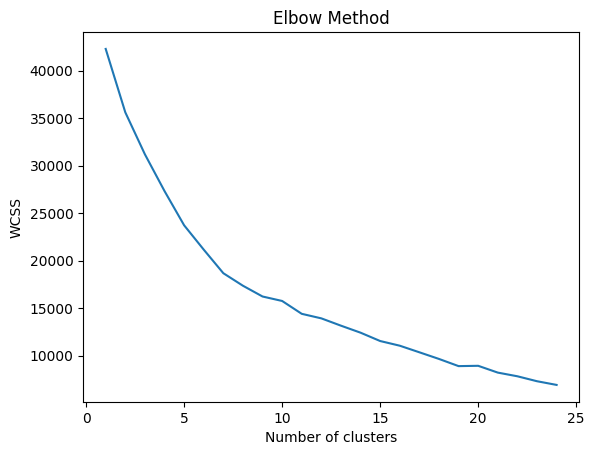

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the number of clusters using the elbow method
wcss = []
for i in range(1, 25):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0
    )
    kmeans.fit(category_reduced)
    wcss.append(kmeans.inertia_)

In [9]:
# Choose the number of clusters as where the elbow occurs
n_clusters = 8

# Apply K-Means clustering
kmeans = KMeans(
    n_clusters=n_clusters, init="k-means++", max_iter=300, n_init=10, random_state=0
)
test_info["Category_Cluster"] = kmeans.fit_predict(category_reduced)
test_info["TestName_Cluster"] = kmeans.fit_predict(testname_reduced)

# Check the silhouette score
from sklearn.metrics import silhouette_score

silhouette_cat = silhouette_score(category_reduced, test_info["Category_Cluster"])
silhouette_test = silhouette_score(testname_reduced, test_info["TestName_Cluster"])
print(f"Silhouette Score for Category: {silhouette_cat}")
print(f"Silhouette Score for Test Name: {silhouette_test}")

Silhouette Score for Category: 0.43301865458488464
Silhouette Score for Test Name: 0.08939405530691147


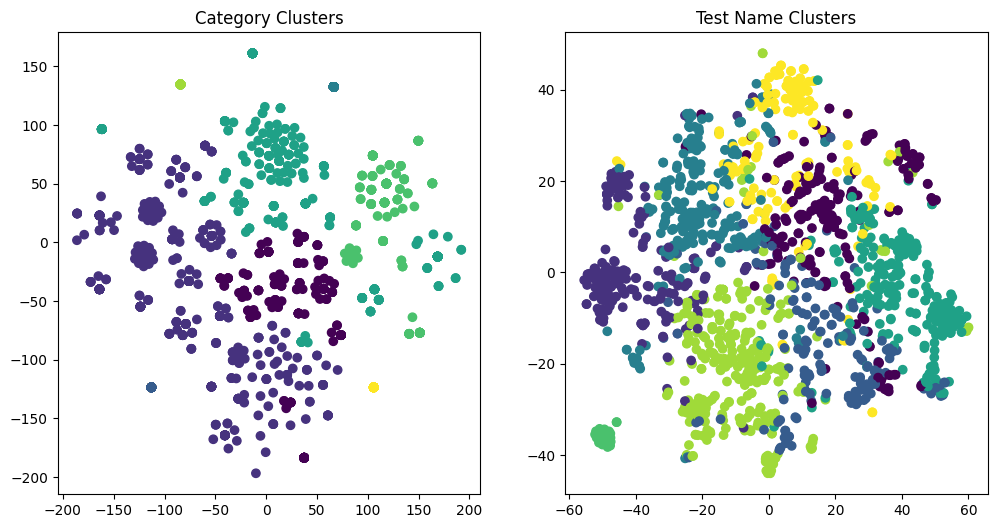

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to two dimensions
tsne = TSNE(n_components=2, random_state=0)
category_2d = tsne.fit_transform(category_reduced)
testname_2d = tsne.fit_transform(testname_reduced)

# Plotting the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(category_2d[:, 0], category_2d[:, 1], c=test_info["Category_Cluster"])
plt.title("Category Clusters")

plt.subplot(1, 2, 2)
plt.scatter(testname_2d[:, 0], testname_2d[:, 1], c=test_info["TestName_Cluster"])
plt.title("Test Name Clusters")

plt.show()

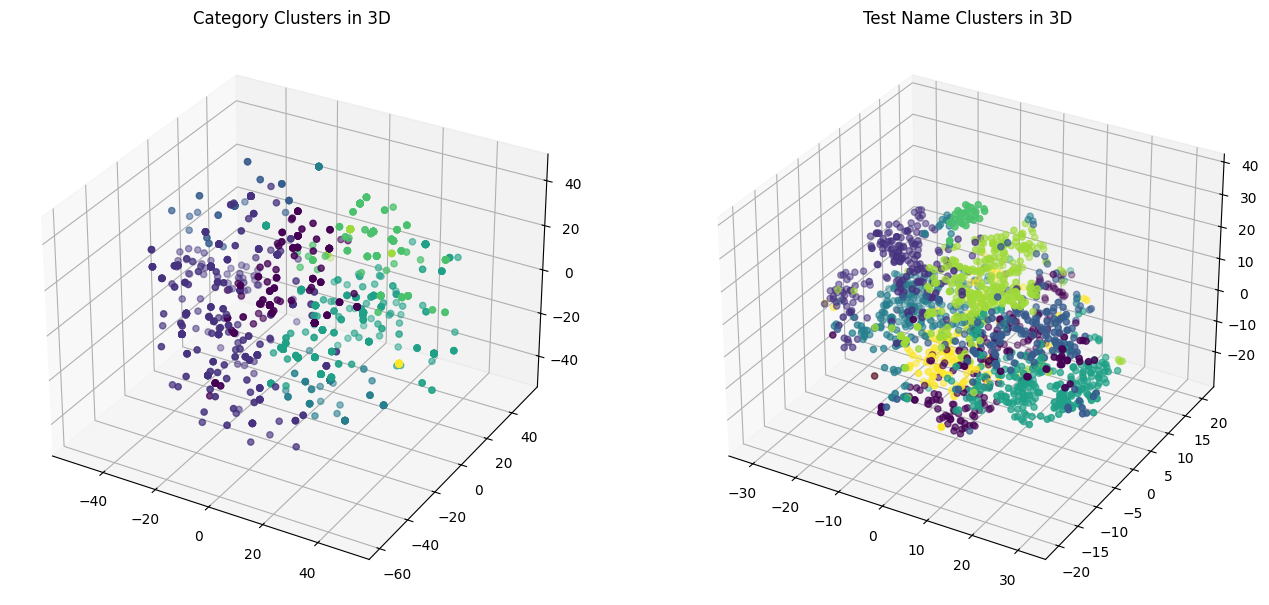

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Reduce dimensions to 3 components for 3D visualization
tsne_3d = TSNE(n_components=3, random_state=0)
category_3d = tsne_3d.fit_transform(category_reduced)
testname_3d = tsne_3d.fit_transform(testname_reduced)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(16, 8))

# Category clusters
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(
    category_3d[:, 0],
    category_3d[:, 1],
    category_3d[:, 2],
    c=test_info["Category_Cluster"],
)
ax1.set_title("Category Clusters in 3D")

# Test Name clusters
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(
    testname_3d[:, 0],
    testname_3d[:, 1],
    testname_3d[:, 2],
    c=test_info["TestName_Cluster"],
)
ax2.set_title("Test Name Clusters in 3D")

plt.show()

In [5]:
from transformers import AutoTokenizer, AutoModel, BertModel
import torch

# BERT Model und Tokenizer laden
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# move model to cuda if cuda is available
model = model.to("cuda") if torch.cuda.is_available() else model


def get_bert_embedding(text):
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=128
    )

    # move inputs to cuda if cuda is available
    inputs = (
        {k: v.to("cuda") for k, v in inputs.items()}
        if torch.cuda.is_available()
        else inputs
    )

    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()


def get_bert_embedding_for_list(list_of_text):
    return [get_bert_embedding(text) for text in list_of_text]


# Embeddings für jede Zeile berechnen
test_info["Category_Embedding"] = test_info["Category"].apply(get_bert_embedding)
test_info["TestName_Embedding"] = test_info["Test Name"].apply(get_bert_embedding)
test_specs["expectedResult"] = test_specs["expectedResult"].apply(
    get_bert_embedding_for_list
)
test_specs["stepsToReproduce"] = test_specs["stepsToReproduce"].apply(
    get_bert_embedding_for_list
)